In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import os
import gc

from shared.utils import *
from shared.local_path import *

from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Data Preprocessing
## Image Data

In [2]:
filepath = []
label = []

i = 0
for classes in os.listdir(TRAIN_IMAGE_PATH):
    for file in os.listdir(os.path.join(TRAIN_IMAGE_PATH, classes)):
        path = os.path.join(TRAIN_IMAGE_PATH, classes, file)
        filepath.append(path)
        label.append(classes)

train_df = pd.DataFrame({
    'filepath': filepath,
    'label': label
})

del filepath, label

print(train_df.shape)
print(train_df['label'].unique())
train_df.head()

(33228, 2)
['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


,filepath,label
0,E:\\Skripsi\data\new_data\train\angry\angry_0_...,angry
1,E:\\Skripsi\data\new_data\train\angry\angry_0_...,angry
2,E:\\Skripsi\data\new_data\train\angry\angry_0_...,angry
3,E:\\Skripsi\data\new_data\train\angry\angry_0_...,angry
4,E:\\Skripsi\data\new_data\train\angry\angry_0_...,angry


In [3]:
filepath = []
label = []

i = 0
for classes in os.listdir(TEST_IMAGE_PATH):
    for file in os.listdir(os.path.join(TEST_IMAGE_PATH, classes)):
        path = os.path.join(TEST_IMAGE_PATH, classes, file)
        filepath.append(path)
        label.append(classes)

img_test_df = pd.DataFrame({
    'filepath': filepath,
    'label': label
})

del filepath, label

print(img_test_df.shape)
print(img_test_df['label'].unique())
img_test_df.head()

(7311, 2)
['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


,filepath,label
0,E:\\Skripsi\data\new_data\test\angry\Anger.jpg,angry
1,E:\\Skripsi\data\new_data\test\angry\Anger_1.jpg,angry
2,E:\\Skripsi\data\new_data\test\angry\Anger_10.jpg,angry
3,E:\\Skripsi\data\new_data\test\angry\Anger_11.jpg,angry
4,E:\\Skripsi\data\new_data\test\angry\Anger_12.jpg,angry


In [4]:
le = LabelEncoder()
le.fit(train_df['label'])
train_df['label_encoded'] = le.transform(train_df['label'])
img_test_df['label_encoded'] = le.transform(img_test_df['label'])

In [5]:
with tf.device('/GPU:0'):
    train_df['data'] = train_df['filepath'].apply(lambda x: preprocess_image(x, (100, 100)))
    img_test_df['data'] = img_test_df['filepath'].apply(lambda x: preprocess_image(x, (100, 100)))
    train_df = train_df.sample(frac=1).reset_index(drop=True)
    
train_df.shape

(33228, 4)

In [6]:
x_img = np.stack(train_df['data'].values)
y_img = train_df['label_encoded'].values

x_img_val = np.stack(img_test_df['data'].values)
y_img_val = img_test_df['label_encoded'].values
del train_df, img_test_df

In [7]:
x_img_train, x_img_test, y_img_train, y_img_test = train_test_split(x_img, y_img, test_size=0.2, random_state=100, stratify=y_img)
del x_img, y_img

In [9]:
from collections import Counter

print(Counter(y_img_train))
print(Counter(y_img_val))
print(Counter(y_img_test))

Counter({4: 3972, 5: 3864, 6: 3828, 3: 3800, 2: 3767, 0: 3753, 1: 3598})
Counter({3: 1793, 5: 1266, 4: 1252, 2: 1043, 0: 977, 6: 850, 1: 130})
Counter({4: 993, 5: 966, 6: 957, 3: 950, 2: 942, 0: 939, 1: 899})


In [10]:
print(y_img_train.shape)
print(y_img_val.shape)
print(y_img_test.shape)

(26582,)
(7311,)
(6646,)


# Modeling
## Model Image

In [11]:
base_model = tf.keras.applications.VGG19(
    weights='imagenet',
    include_top=False,
    input_tensor=tf.keras.layers.Input(shape=(100, 100, 3)),
)

for layer in base_model.layers:
    layer.trainable = False

In [12]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax'),
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'],
)

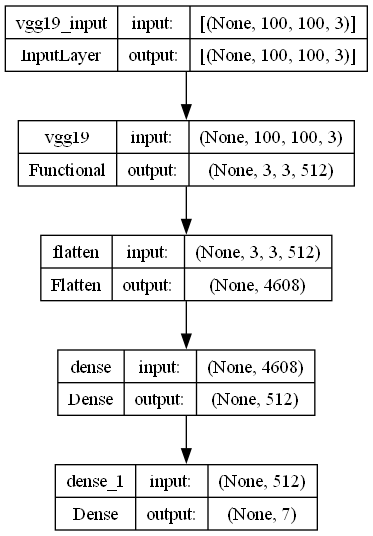

In [13]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [14]:
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    restore_best_weights=True,
    mode='min',
    # start_from_epoch=2,
    patience=5
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join('model', 'best_model.keras'),
    verbose=2,
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                    factor=0.2,
                                                    min_lr=1e-6,
                                                    patience=3,
                                                    mode='min'
                                                    )

In [15]:
history = model.fit(
    x_img_train,
    y_img_train,
    validation_data=(x_img_val, y_img_val),
    callbacks=[checkpoint, lr_scheduler],
    epochs=50,
    verbose=2,
    batch_size=BATCH_SIZE,
    steps_per_epoch=len(x_img_train) // BATCH_SIZE,
    validation_steps=len(x_img_val) // BATCH_SIZE,
)


Epoch 1/50

Epoch 1: val_loss improved from inf to 1.63124, saving model to model\best_model.keras
415/415 - 33s - loss: 2.8668 - accuracy: 0.3575 - val_loss: 1.6312 - val_accuracy: 0.3714 - lr: 0.0010 - 33s/epoch - 81ms/step
Epoch 2/50

Epoch 2: val_loss improved from 1.63124 to 1.52117, saving model to model\best_model.keras
415/415 - 28s - loss: 1.3582 - accuracy: 0.4851 - val_loss: 1.5212 - val_accuracy: 0.4352 - lr: 0.0010 - 28s/epoch - 67ms/step
Epoch 3/50

Epoch 3: val_loss did not improve from 1.52117
415/415 - 26s - loss: 1.1867 - accuracy: 0.5507 - val_loss: 1.5388 - val_accuracy: 0.4490 - lr: 0.0010 - 26s/epoch - 63ms/step
Epoch 4/50

Epoch 4: val_loss did not improve from 1.52117
415/415 - 27s - loss: 1.0657 - accuracy: 0.5953 - val_loss: 1.5792 - val_accuracy: 0.4431 - lr: 0.0010 - 27s/epoch - 64ms/step
Epoch 5/50

Epoch 5: val_loss did not improve from 1.52117
415/415 - 27s - loss: 0.9502 - accuracy: 0.6405 - val_loss: 1.6373 - val_accuracy: 0.4393 - lr: 0.0010 - 27s/epoc

# Evaluate Model
## Using the model.evaluate
### using test set

In [16]:
print(model.evaluate(x_img_test, y_img_test, batch_size=BATCH_SIZE, steps=len(x_img_test) // BATCH_SIZE))

103/103 [==============================] - 5s 53ms/step - loss: 1.7691 - accuracy: 0.5281
[1.7690691947937012, 0.5280643105506897]


### Using validation set

In [17]:
print(model.evaluate(x_img_val, y_img_val, batch_size=BATCH_SIZE, steps=len(x_img_val) // BATCH_SIZE))

114/114 [==============================] - 6s 54ms/step - loss: 2.0254 - accuracy: 0.4696
[2.0254015922546387, 0.46957236528396606]


In [18]:
def plot_and_save(metric_name, history, ylabel, filename):
    plt.figure()
    plt.plot(history.history[metric_name], label=f'Train {ylabel}')
    if f'val_{metric_name}' in history.history:
        plt.plot(history.history[f'val_{metric_name}'], label=f'Val {ylabel}')
    plt.title(f'{ylabel} over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.savefig(filename)
    plt.close()

In [19]:
plot_and_save('loss', history, 'Loss', 'image_loss_plot.png')
plot_and_save('accuracy', history, 'Image Classification Accuracy', 'image_class_accuracy_plot.png')

In [20]:
predictions = model.predict(x_img_test)
predictions = np.argmax(predictions, axis=1)

208/208 [==============================] - 6s 25ms/step


In [21]:
classes = [x for x in os.listdir(TRAIN_IMAGE_PATH)]
print(classes)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


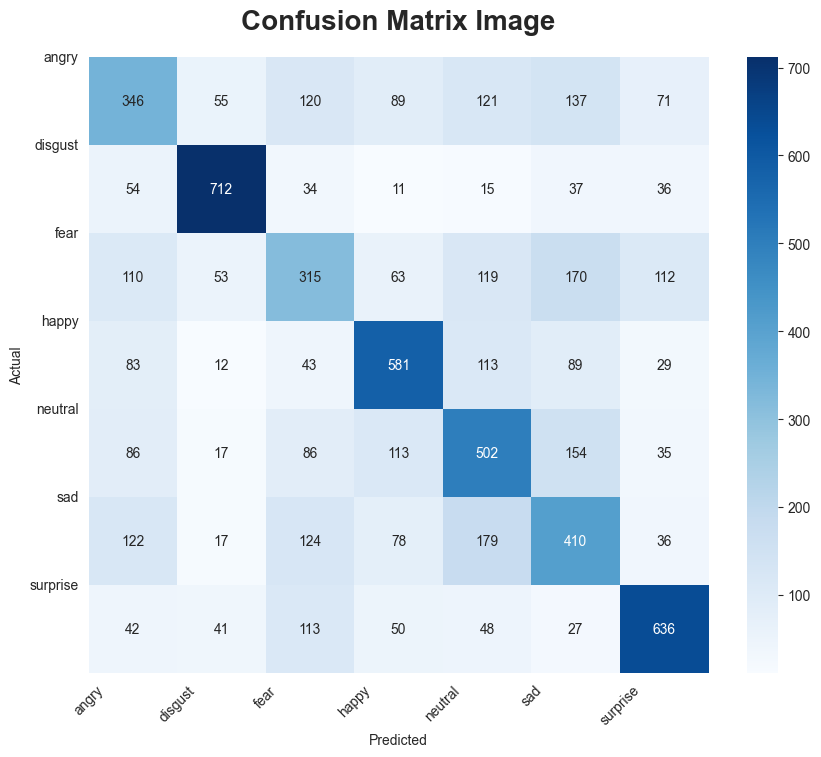

In [22]:
cm = confusion_matrix(y_img_test, predictions)

plt.figure(figsize=(10, 8))  # Set the figure size if needed
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')

plt.title('Confusion Matrix Image', pad=20, fontsize=20, fontweight="bold")
plt.ylabel('Actual')
plt.xlabel('Predicted')

# Set ticks for the x and y axes using class names
plt.xticks(ticks=range(len(classes)), labels=classes, rotation=45)
plt.yticks(ticks=range(len(classes)), labels=classes, rotation=0)
plt.savefig('confusion_matrix_img.png', dpi=300, bbox_inches='tight')
plt.show()

In [23]:
print(classification_report(predictions, y_img_test))

              precision    recall  f1-score   support

           0       0.37      0.41      0.39       843
           1       0.79      0.79      0.79       907
           2       0.33      0.38      0.35       835
           3       0.61      0.59      0.60       985
           4       0.51      0.46      0.48      1097
           5       0.42      0.40      0.41      1024
           6       0.66      0.67      0.67       955

    accuracy                           0.53      6646
   macro avg       0.53      0.53      0.53      6646
weighted avg       0.53      0.53      0.53      6646



In [24]:
model.save('model_img.h5')